## Demuxalot + detection of new SNPs

an example of demultiplexing using a single bamfile

(demuxalot can deal with multiple bamfiles simulteneously - it is far more efficient than merging bamfiles,
but not shown in this tutorial)

We only need some amount of information about each genotype.
New SNPs found without any reference (like 1000 Genomes or so) and tailored specifically for your case.

In [1]:
import os
from pathlib import Path
import pandas as pd
import pysam

from demuxalot.utils import download_file
from demuxalot import BarcodeHandler, ProbabilisticGenotypes, Demultiplexer, count_snps, detect_snps_positions

In [2]:
local_path = Path.home().joinpath('demuxalot_examples/new_snps_simplified')
local_path.mkdir(exist_ok=True, parents=True)
os.chdir(local_path)

In [3]:
bamfile_location = download_file("https://sra-pub-src-1.s3.amazonaws.com/SRR5398237/C.merged.bam.1", "C.merged.bam")

vcf_filename = download_file(
    "https://github.com/yelabucsf/demuxlet_paper_code/raw/master/fig2/b1.b2.b3.merged_32.eagle.hrc.imputed.autosomes.dose.mac1.exon.recode.vcf.gz",
    "32_donors.vcf",
)

barcode_filename = download_file('https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM2560247&format=file&file=GSM2560247%5Fbarcodes%2Etsv%2Egz', 'barcodes/C.tsv.gz')

downloaded to C.merged.bam
file 32_donors.vcf already exists locally
file barcodes/C.tsv.gz already exists locally


In [4]:
handler = BarcodeHandler.from_file(barcode_filename)

# well, that's the names that were used in the original data.
# Recommendation: use better names when you do the same,
# like Donor6, Donor11, ...
genotype_names = [
    '6', '11', '12', '13', '15', '16', '18', '21',
    '1015', '1016', '1026', '1043', '1039', '1112', '1012',
    '1249', '1244', '1066', '1488', '1511', '1311', '1286',
    '1256', '1493', '1442', '1453', '1598', '1085', '1079',
    '1154', '107', '101'
]
genotype_names.sort()
genotypes = ProbabilisticGenotypes(genotype_names=genotype_names)
# prior_strength reflects the confidence in assigned genotypes.
# Should be related to scrnaseq read. Confidence of assignment ~100 reads from rnaseq
genotypes.add_vcf(vcf_filename, prior_strength=100)

[E::idx_find_and_load] Could not retrieve index file for '32_donors.vcf'


Parsed 189321 SNPs, got 378411 novel variants


In [5]:
if not Path(bamfile_location + '.bai').exists():
    # index alignments file and check integrity
    pysam.index(bamfile_location)

In [6]:
counts = count_snps(
    bamfile_location=bamfile_location,
    chromosome2positions=genotypes.get_chromosome2positions(),
    barcode_handler=handler,
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  22 | elapsed:  1.8min remaining: 17.9min
[Parallel(n_jobs=-1)]: Done   5 out of  22 | elapsed:  2.2min remaining:  7.6min
[Parallel(n_jobs=-1)]: Done   8 out of  22 | elapsed:  2.8min remaining:  4.8min
[Parallel(n_jobs=-1)]: Done  11 out of  22 | elapsed:  2.9min remaining:  2.9min
[Parallel(n_jobs=-1)]: Done  14 out of  22 | elapsed:  3.1min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done  17 out of  22 | elapsed:  3.3min remaining:   58.6s
[Parallel(n_jobs=-1)]: Done  20 out of  22 | elapsed:  4.1min remaining:   24.3s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:  5.4min finished


,n_molecules,n_snp_calls
chromosome,,
1,127873,170086
10,32521,49631
11,96455,139213
12,84067,120895
13,13085,17340
14,48578,77595
15,120039,227538
16,128195,159872
17,78840,119150


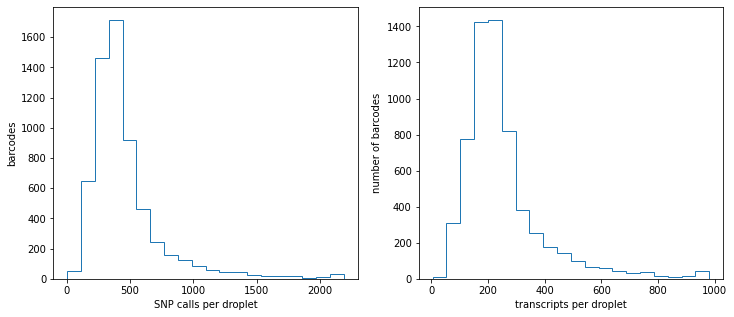

In [7]:
from demuxalot import utils
utils.summarize_counted_SNPs(counts)

## Enrichment with new SNPs

In [8]:
new_snps_filename = 'new_snps_single_file.betas'
_ = detect_snps_positions(
    bamfile_location=str(bamfile_location),
    genotypes=genotypes,
    barcode_handler=handler,
    minimum_coverage=200,
    minimum_alternative_coverage=10,
    result_beta_prior_filename=new_snps_filename,
    n_best_snps_per_donor=100,
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  22 | elapsed:  1.8min remaining: 18.4min
[Parallel(n_jobs=-1)]: Done   5 out of  22 | elapsed:  2.3min remaining:  7.7min
[Parallel(n_jobs=-1)]: Done   8 out of  22 | elapsed:  2.9min remaining:  5.0min
[Parallel(n_jobs=-1)]: Done  11 out of  22 | elapsed:  2.9min remaining:  2.9min
[Parallel(n_jobs=-1)]: Done  14 out of  22 | elapsed:  3.1min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  17 out of  22 | elapsed:  3.3min remaining:   58.0s
[Parallel(n_jobs=-1)]: Done  20 out of  22 | elapsed:  4.1min remaining:   24.5s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:  5.3min finished


Number of SNPs used for each donor during inference
101       1
1043    808
1079    774
1085    809
1154    805
1249    698
1311      1
1493    660
1511    890
1598    686
dtype: int64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 out of 382 | elapsed:   54.1s remaining:  9.5min
[Parallel(n_jobs=-1)]: Done  68 out of 382 | elapsed:  1.8min remaining:  8.4min
[Parallel(n_jobs=-1)]: Done 103 out of 382 | elapsed:  3.0min remaining:  8.2min
/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done 138 out of 382 | elapsed:  4.7min remaining:  8.4min
[Parallel(n_jobs=-1)]: Done 173 out of 382 | elapsed:  5.5min remaining:  6.7min
[Parallel(n_jobs=-1)]: Done 208 out of 382 | elapsed:  6.1min remaining:  5.1min
[Parallel(n_jobs=-1)]: Done 243 out of 382 | elapsed:  6.8min remaining:  3.9min
[Parallel(n_jobs=-1)]: Done 278 out of 382 | elapsed:  7.7min remaining:  2.9min
[Parallel(n_jobs=-1)]: Done 

In [9]:
genotypes_with_new_snps = genotypes.clone()
# adding new positions to genotypes
# since there is indeed only positions, no any genotype-specific information
genotypes_with_new_snps.add_prior_betas(new_snps_filename, prior_strength=1)

Provided prior information about genotypes: []
No information for genotypes: ['101', '1012', '1015', '1016', '1026', '1039', '1043', '1066', '107', '1079', '1085', '11', '1112', '1154', '12', '1244', '1249', '1256', '1286', '13', '1311', '1442', '1453', '1488', '1493', '15', '1511', '1598', '16', '18', '21', '6']


In [10]:
# counting with new SNPs
counts_enriched = count_snps(
    bamfile_location=str(bamfile_location),
    chromosome2positions=genotypes_with_new_snps.get_chromosome2positions(),
    barcode_handler=handler,
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of  27 | elapsed:  1.3min remaining: 34.8min
[Parallel(n_jobs=-1)]: Done   4 out of  27 | elapsed:  2.3min remaining: 13.1min
[Parallel(n_jobs=-1)]: Done   7 out of  27 | elapsed:  2.7min remaining:  7.8min
[Parallel(n_jobs=-1)]: Done  10 out of  27 | elapsed:  3.0min remaining:  5.1min
[Parallel(n_jobs=-1)]: Done  13 out of  27 | elapsed:  3.1min remaining:  3.3min
[Parallel(n_jobs=-1)]: Done  16 out of  27 | elapsed:  3.3min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done  19 out of  27 | elapsed:  3.3min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  22 out of  27 | elapsed:  3.5min remaining:   47.2s
[Parallel(n_jobs=-1)]: Done  25 out of  27 | elapsed:  4.2min remaining:   20.3s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  5.5min finished


In [11]:
learnt_enriched_genotypes, probs_learning_new_snps = Demultiplexer.learn_genotypes(
    counts_enriched,
    genotypes_with_new_snps,
    barcode_handler=handler,
    doublet_prior=0.25,
)

In [12]:
probs_learning_new_snps.head()

,101,1012,1015,1016,1026,1039,1043,1066,107,1079,...,1598+16,1598+18,1598+21,1598+6,16+18,16+21,16+6,18+21,18+6,21+6
AAACATACCTAGAC-1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.416119e-18,4.153942e-21,9.072983e-19,2.416512e-21,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
AAACATACGGTAGG-1,5.893444e-25,1.616812e-24,7.466817e-35,7.447178e-23,3.101730e-26,1.084200e-28,9.997730e-01,1.620205e-28,1.013787e-27,4.656477e-27,...,3.391982e-19,3.610624e-18,6.178274e-19,5.692537e-20,2.869438e-21,1.059694e-22,1.680592e-22,2.783553e-21,1.973278e-21,7.332391e-23
AAACATTGCGGAGA-1,0.000000e+00,2.326716e-41,0.000000e+00,3.918717e-38,0.000000e+00,2.641881e-33,2.793027e-31,1.608927e-29,1.968578e-29,5.268882e-43,...,7.551176e-27,3.355862e-30,2.124797e-25,8.072488e-32,1.326743e-29,1.033131e-28,8.026980e-32,9.241092e-29,1.490514e-36,4.828426e-29
AAACATTGTGGTCA-1,2.724481e-29,3.558636e-25,7.128015e-27,4.519256e-21,4.421980e-30,1.103842e-31,1.242284e-26,1.433674e-24,2.344102e-29,1.310178e-18,...,4.190151e-20,1.728635e-16,2.003620e-19,3.751633e-19,1.267069e-22,4.440428e-27,1.480551e-22,5.169028e-23,7.700729e-19,7.410580e-26
AAACCGTGAAAAGC-1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,3.304900e-18,1.980833e-15,1.309289e-17,3.008644e-16,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [13]:
# if you need only assignments:
probs_learning_new_snps[probs_learning_new_snps.max(axis=1).gt(0.9)].idxmax(axis=1)

# note that threshold should be adjusted according to 1) your confidence in data 2) how pure your sample should be for analysis.
# Threshold of 0.9 is ok for a vast majority of use-cases

AAACATACCTAGAC-1    1598
AAACATACGGTAGG-1    1043
AAACATTGCGGAGA-1    1085
AAACATTGTGGTCA-1    1511
AAACCGTGAAAAGC-1    1598
                    ... 
TTTGACTGTGCCCT-1    1493
TTTGCATGAGCATC-1    1085
TTTGCATGCATTGG-1    1249
TTTGCATGTATCGG-1    1493
TTTGCATGTTTCTG-1    1493
Length: 6112, dtype: object

## For comparison: if we skipped SNP detection, pipeline would look like this:

In [14]:
_posterior_logits, probs_without_learning = Demultiplexer.predict_posteriors(
    counts,
    genotypes,
    barcode_handler=handler,
    doublet_prior=0.25,
)

In [15]:
genotypes_improved, probs_with_learning = Demultiplexer.learn_genotypes(
    counts,
    genotypes=genotypes,
    barcode_handler=handler,
    doublet_prior=0.25,
)

In [16]:
_, probs_learning_new_snps_replica = Demultiplexer.predict_posteriors(
    counts,
    learnt_enriched_genotypes,
    barcode_handler=handler,
    doublet_prior=0.25,
)

In [17]:
pd.DataFrame({
    'no learning': probs_without_learning[genotype_names].sum(),
    'learning': probs_with_learning[genotype_names].sum(),
    'with new SNPs': probs_learning_new_snps[genotype_names].sum(),
    'with new SNPs replica': probs_learning_new_snps_replica[genotype_names].sum(),
})

,no learning,learning,with new SNPs,with new SNPs replica
101,0.646361,0.208113,0.055152,0.164370
1012,0.077494,0.078445,0.042626,0.078315
1015,0.069088,0.072375,0.028998,0.069680
1016,0.076472,0.078753,0.037509,0.078346
1026,0.112641,0.113556,0.041981,0.113519
1039,0.027643,0.025233,0.006196,0.025292
1043,763.273193,768.629333,769.489258,768.749023
1066,0.205595,0.224246,0.149512,0.209892
107,0.047433,0.048027,0.011478,0.047541
1079,706.252808,737.777405,738.297424,737.923035


In [29]:
pd.DataFrame({
    'no learning': probs_without_learning[genotype_names].sum(),
    'learning': probs_with_learning[genotype_names].sum(),
    'with new SNPs': probs_learning_new_snps[genotype_names].sum(),
    'with new SNPs replica': probs_learning_new_snps_replica[genotype_names].sum(),
})

,no learning,learning,with new SNPs,with new SNPs replica
101,0.683443,0.194203,0.058715,0.224822
1012,0.082679,0.083878,0.045124,0.083729
1015,0.066046,0.067257,0.031405,0.072657
1016,0.079092,0.081217,0.037064,0.081679
1026,0.120748,0.122110,0.044754,0.121060
1039,0.017777,0.016033,0.000314,0.016949
1043,766.485128,770.147469,771.521899,771.260134
1066,0.226480,0.235499,0.166581,0.259100
107,0.050697,0.051025,0.012036,0.051492
1079,703.630471,738.593162,739.359608,740.836566
